In [218]:
import seaborn as sns
from matplotlib import dates
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
import tabulate
warnings.filterwarnings('ignore')
# sns.set(font_scale=5.5)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
df_hrv = pd.read_csv("../data/original/HeartRateVariabilitySDNN.csv")
# df_hrv.head()

# df_new = pd.DataFrame(index=df_hrv.index)
# df_new['date'] = pd.to_datetime(df_hrv['creationDate'])
# df_new['hrv'] = df_hrv['value']
# new_date = []


# for (index, row) in df_new.iterrows():
#     new_date.append(np.datetime64('2005-02-25T03:30'))


# df_new['new date'] = new_date 
# df_new['new date'] = df_new['new date'].values.astype(float)  
# df_new.head()

# from pandas.plotting import autocorrelation_plot





In [219]:
def parse_date(x):
    return pd.datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S')

series = pd.read_csv('../data/original/HeartRateVariabilitySDNN.csv', header=0, index_col=5, parse_dates=[5], squeeze=True, date_parser=parse_date)

df_new = pd.DataFrame()
df_new['value'] = series['value'].resample('H').mean().interpolate()
df_new['creationDate'] = pd.to_datetime(df_new.index)
df_new = df_new.reset_index(drop=True)

df_new['t+1'] = df_new['value'].shift(periods=1)
df_new['t+24'] = df_new['value'].shift(periods=24)
df_new.head()



,value,creationDate,t+1,t+24
0,38.75470,2018-01-16 09:00:00,NaN,NaN
1,36.47938,2018-01-16 10:00:00,38.75470,NaN
2,34.20406,2018-01-16 11:00:00,36.47938,NaN
3,31.92874,2018-01-16 12:00:00,34.20406,NaN
4,29.65342,2018-01-16 13:00:00,31.92874,NaN


In [220]:
df_hrv_filtered = df_new

# convert from string to datetime
# df_hrv_filtered['creationDate'] = pd.to_datetime(df_hrv_filtered['creationDate'])
# mean per day
# df_hrv_final = df_hrv_filtered.groupby(df_hrv_filtered['creationDate'].dt.date).mean()

df_hrv_filtered.head()
    

,value,creationDate,t+1,t+24
0,38.75470,2018-01-16 09:00:00,NaN,NaN
1,36.47938,2018-01-16 10:00:00,38.75470,NaN
2,34.20406,2018-01-16 11:00:00,36.47938,NaN
3,31.92874,2018-01-16 12:00:00,34.20406,NaN
4,29.65342,2018-01-16 13:00:00,31.92874,NaN


,date,HRV (SDNN),Is at Work (binary),Is Above Mean Value,Hour of Day,Day of Week,Is Morning,t+1
0,2018-01-16 09:00:00,38.75470,1,0,9,2,1,NaN
1,2018-01-16 10:00:00,36.47938,1,0,10,2,1,38.75470
2,2018-01-16 11:00:00,34.20406,1,0,11,2,1,36.47938
3,2018-01-16 12:00:00,31.92874,1,0,12,2,0,34.20406
4,2018-01-16 13:00:00,29.65342,1,0,13,2,0,31.92874


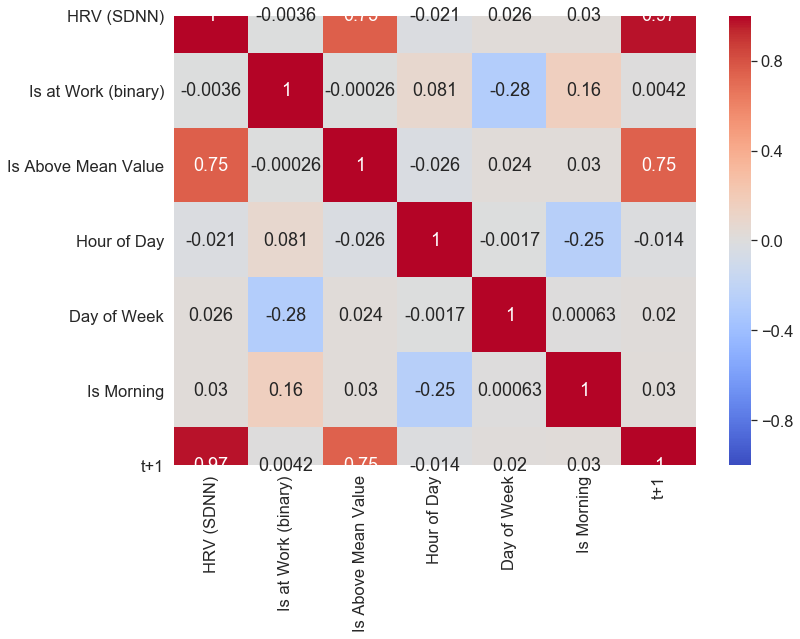

In [221]:
scaler = StandardScaler()
hrv_merged = pd.DataFrame()

def at_work(row):
#     print(row['creationDate'].hour)
#     derp = row['creationDate'].hour
    hour = row['creationDate'].hour
    weekday = row['creationDate'].isoweekday()
    
    if((hour >= 9 and hour <17) and weekday < 6):
        # print(pd.to_datetime(row['creationDate']), (weekday))
        return 1
    return 0
    
# winter is from 1st of November to 1st of April
def is_winter(row):
    month = pd.to_datetime(row['creationDate'], format='%d/%m').month
    
    if(month >= 10 or month < 4):
        return 1
    return 0

def is_higher_than_mean(row):
    mean = 41.25
    if row.value > mean:
        return 1
    return 0

def get_hour_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    return hour

def get_day_of_week(row):
    weekday = pd.to_datetime(row['creationDate']).isoweekday()
    return weekday

def get_time_of_day(row):
    hour = pd.to_datetime(row['creationDate']).hour
    
    if((hour >= 6 and hour <12)):
        return 1
    return 0
    
    
hrv_merged['date'] = df_hrv_filtered['creationDate']
hrv_merged['HRV (SDNN)'] = df_hrv_filtered['value']

work_hours = []
winter_time = []
above_mean = []
hour_of_day = []
day_of_week = []
time_of_day = [] # is morning or afternoon



for (index, row) in df_hrv_filtered.iterrows():

        
    work_hours.append(at_work(row))
#     winter_time.append(is_winter(row))
    above_mean.append(is_higher_than_mean(row))
    hour_of_day.append(get_hour_of_day(row))
    day_of_week.append(get_day_of_week(row))
    time_of_day.append(get_time_of_day(row))
    if (row['value'] > 150):
        df_hrv_filtered.drop(index, inplace=True)
    
hrv_merged['Is at Work (binary)'] = work_hours
hrv_merged['Is Above Mean Value'] = above_mean
hrv_merged['Hour of Day'] = hour_of_day
hrv_merged['Day of Week'] = day_of_week
hrv_merged['Is Morning'] = time_of_day
# hrv_merged['new date'] = hrv_merged['date'].astype(np.int64).values.reshape(-1,1)
hrv_merged['t+1'] = df_hrv_filtered['t+1']

hrv_merged.to_csv('../data/hrv_shaped.csv')

sns.heatmap(hrv_merged.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

hrv_merged.head()

# hrv_copy = hrv_merged.set_index('date')
# hrv_scaled = scaler.fit_transform(hrv_copy)

# print(tabulate(hrv_summary, tablefmt="pipe", headers="keys"))
# results.head()

# hrv_copy = hrv_merged.set_index('date')

# hrv_copy.head()
# hrv_scaled = scaler.fit_transform(hrv_copy)
# # hrv_summary




# sx = sns.lineplot(x="date", y="HRV (SDNN)", data=hrv_merged)
# sx.set(xlim = (pd.to_datetime('2018-01-13'), pd.to_datetime('2019-10-31')))

# sx.set_title('HRV', fontsize=20)

# for item in sx.get_xticklabels():
#     item.set_rotation(45)
# hrv_merged.hist()

# new_pd = pd.DataFrame(hrv_scaled)

# new_pd.head()
# hrv_merged = hrv_merged.set_index('date')
# hrv_scaled = scaler.fit_transform(hrv_copy)
# df_hrv_scaled = pd.DataFrame(hrv_scaled)
# df_hrv_scaled.head(50)

# hrv_copy.head(10)

# fig = sx.get_figure()
# fig.savefig("../report/images/dataset_3.png")


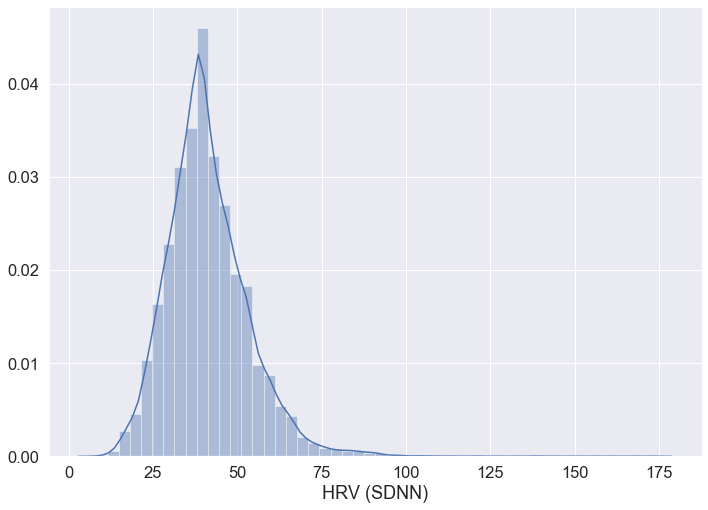

In [222]:
# hrv_merged['HRV (SDNN)'].hist()
sns.distplot(hrv_merged['HRV (SDNN)'])

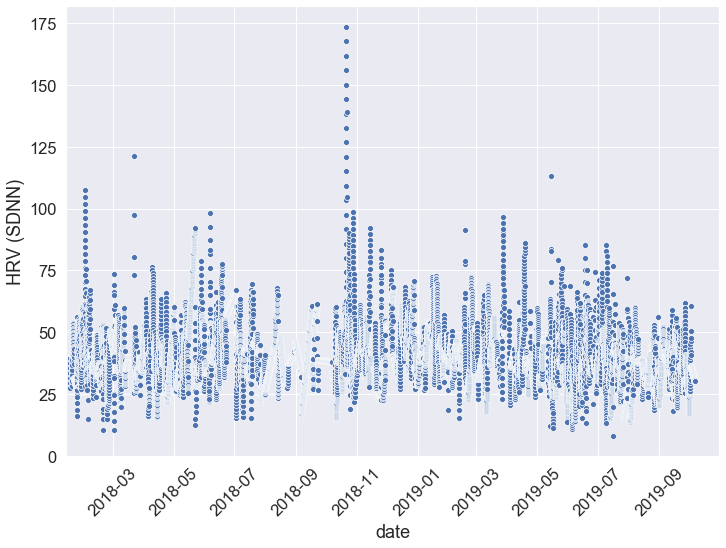

In [223]:
ax = sns.scatterplot(x=hrv_merged['date'], y=hrv_merged['HRV (SDNN)'], data=hrv_merged)
ax.set(xlim = (pd.to_datetime('2018-01-13'), pd.to_datetime('2019-10-31')))
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [224]:
hrv_copy = hrv_merged.dropna().set_index('date')

hrv_scaled = scaler.fit_transform(hrv_copy)

df_hrv_scaled = pd.DataFrame(hrv_scaled)
df_hrv_scaled.columns = ['HRV', 'At Work', 'Above Mean', 'Hour of day', 'Day of week', 'Is morning', 't+1']
# hrv_copy.head()
# df_hrv_scaled.corr() // It's the same as non-scaled values

df_hrv_scaled.head()


,HRV,At Work,Above Mean,Hour of day,Day of week,Is morning,t+1
0,-0.394288,1.787749,-0.886295,-0.216582,-1.003011,1.731744,-0.204286
1,-0.584178,1.787749,-0.886295,-0.072137,-1.003011,1.731744,-0.393880
2,-0.774069,1.787749,-0.886295,0.072309,-1.003011,-0.577452,-0.583475
3,-0.963959,1.787749,-0.886295,0.216755,-1.003011,-0.577452,-0.773069
4,-1.153850,1.787749,-0.886295,0.361201,-1.003011,-0.577452,-0.962663


# Linear regression

In [225]:
from sklearn import linear_model, model_selection, metrics, preprocessing
import numpy as np

1. Split test and train data sets
2. Determine alpha interval
3. Type cohercion

In [226]:
# stuff = hrv_merged['date'].astype(np.int64).values.reshape(-1,1)
X = df_hrv_scaled['t+1'].values.reshape(-1,1)
# X_raw = df_hrv_scaled[['Above Mean', 'Hour of day']]

# poly_features = preprocessing.PolynomialFeatures(degree=2)
# X = poly_features.fit_transform(X_raw)

y = df_hrv_scaled['HRV']

n_alphas = 100
alphas = np.logspace(-10, 10, n_alphas)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.20)

# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)
print(X[500])


[-0.65804894]


In [227]:
## Non-regularized linear regression
linreg = linear_model.LinearRegression().fit(X_train, y_train)
print('score: ', linreg.score(X_test, y_test))

y_pred_linreg = linreg.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_linreg))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linreg)))

# plt.scatter(X_test, y_test,  color='gray')
# plt.plot(X_test, y_pred, color='red', linewidth=2)
# plt.show()

score:  0.9323957175487436
Mean Squared Error: 0.06718112636404039
Root Mean Squared Error: 0.25919322206423606


## Regularized linear regression

In [228]:
ridgeCV = linear_model.RidgeCV(alphas=alphas, cv=5)
ridgeCV.fit(X_train,y_train)

print('score', ridgeCV.score(X_test, y_test))
print('coef', ridgeCV.coef_)
print('intercept', ridgeCV.intercept_)
print('alpha',ridgeCV.alpha_)

y_pred_ridge = ridgeCV.predict(X_test)

df_actual_vs_pred = []
df_actual_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ridge })
df_actual_vs_pred.head()

# sns.lineplot(data=df_actual_vs_pred)

# df_actual_vs_pred.describe()
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))


# df1 = df_actual_vs_pred.head(25)
# df1.plot(kind='bar',figsize=(16,10))
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.show()


score 0.932409328552183
coef [0.97961016]
intercept 0.001922988856635738
alpha 3.1992671377973845
Mean Squared Error: 0.06716760055607618
Root Mean Squared Error: 0.25916712861795604


[[ 0.15406824]
 [-0.60705685]
 [-0.46665808]
 ...
 [-0.51338511]
 [-0.5571658 ]
 [-0.62215247]]
min 0.25791035909951265


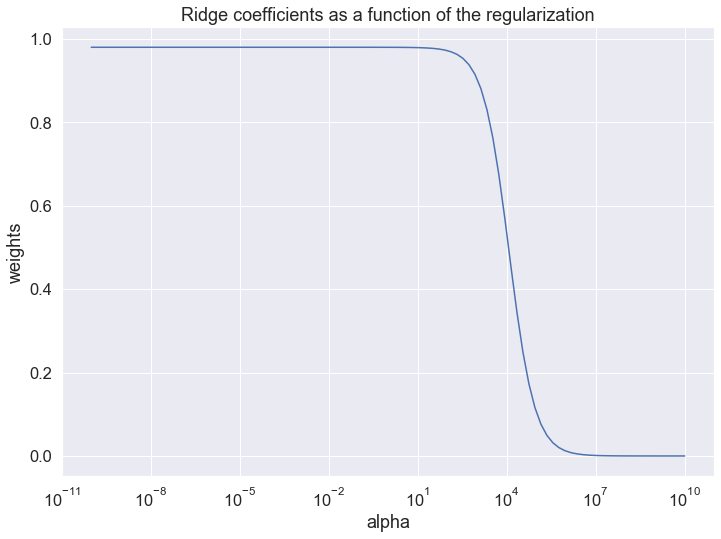

In [249]:
## NOTE: THESE VALUES HAVE TO BE SCALED

print(X_test)

coefs = []
errors = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X_train, y_train)
    y_manual_ridge_pred = ridge.predict(X_test)
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_manual_ridge_pred)), 'alpha', a)
    coefs.append(ridge.coef_)
    errors.append(np.sqrt(metrics.mean_squared_error(y_test, y_manual_ridge_pred)))
    

print('min', min(errors))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [230]:
## NOTE: THESE VALUES SHOULD _NOT_ BE SCALED

# alphas = list(range(0, 10, 0.1))

# print(alphas)

coefs = []
error_train = []
error_test = []

for a in alphas:
#     print(a)
    model = linear_model.Ridge(alpha=a)
    model.fit(X_train,y_train)
#     scores = model_selection.cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv = 10)
#     score_test = model_selection.cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv = 10)
#     score_test = model.score(X_test, y_test)
#     print(model.coef_)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
#     print(y_pred)
#     print(a, model.coef_.mean())
    error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    error_train.append(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    error_test.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
#     print(a, (np.sqrt(-scores).mean()), score_test)
    

df_errors = pd.DataFrame({'lambda': alphas, 'Training Error': error_train, 'Test Error': error_test})
df_errors.columns = ['lambda', 'Training Error', 'Test Error']  
df_errors = df_errors.set_index(-np.log10(alphas))
# df_errors = df_errors.set_index(alphas)



# df_errors.head()
    

[Text(0, 0.5, 'Error (RMSE)'), Text(0.5, 0, '-log10(λ)')]

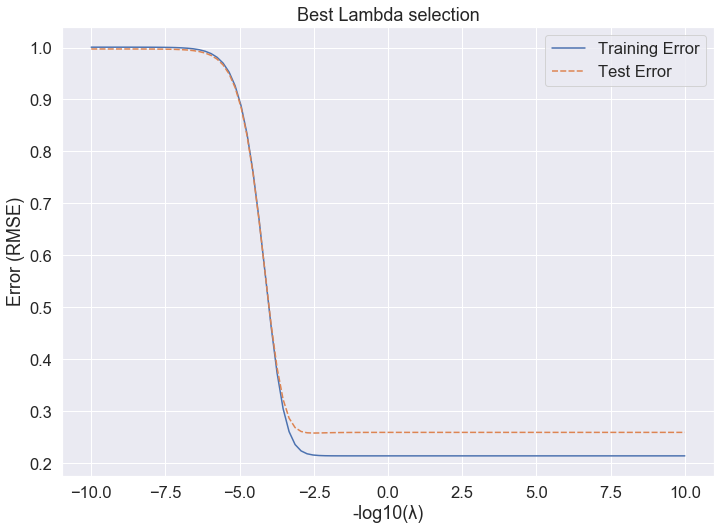

In [231]:
from matplotlib.colors import LogNorm

ex = sns.lineplot(data=df_errors[['Training Error', 'Test Error']])
ex.set_title('Best Lambda selection')
ex.set(xlabel='-log10(λ)', ylabel='Error (RMSE)')


# ex.set(xlim = (0,20))


## Test data set (predictions)

Mean Absolute Error: 0.09070130638895343
Mean Squared Error: 0.06716760055607618
Root Mean Squared Error: 0.25916712861795604


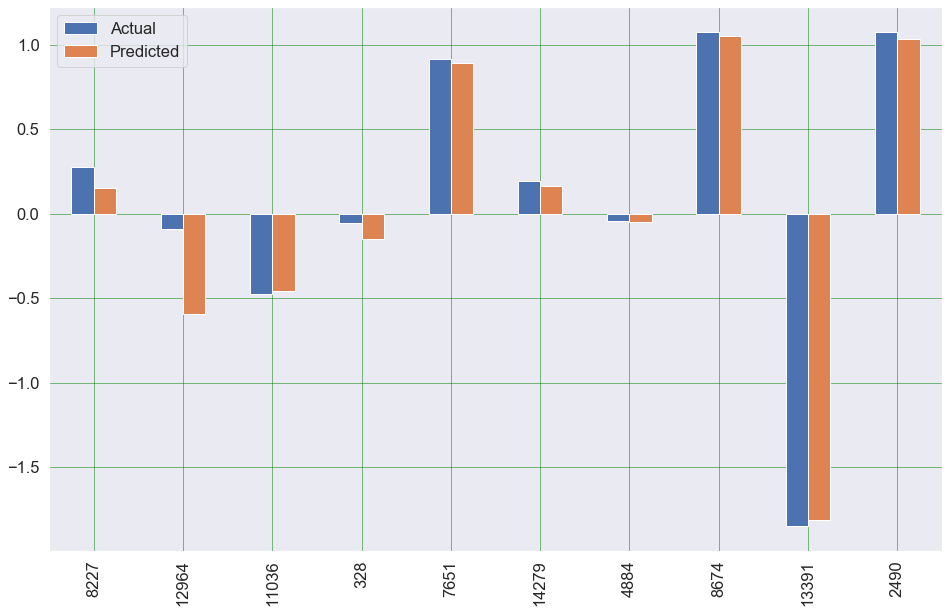

In [232]:
# y_pred = model.predict(X_test)

df_actual_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ridge.flatten() })
df_actual_vs_pred.head()

# print(y_pred_ridge)

# sns.lineplot(data=df_actual_vs_pred['Actual'])

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ridge))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

# df_actual_vs_pred.head(50)

df1 = df_actual_vs_pred.head(10)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()



In [233]:
# plt.scatter(X_train, y_train,  color='gray')
# plt.plot(X_train, y_pred, color='red', linewidth=2)
# plt.show()

In [234]:
# derp = linear_model.LassoCV(cv=10).fit(X_train, y_train)

# print(derp.alpha_)
# # Display results
# m_log_alphas = -np.log10(derp.alphas_)

# plt.figure()
# plt.plot(m_log_alphas, derp.mse_path_, '.')

## Kfolds

In [235]:
from sklearn import model_selection, linear_model, metrics, naive_bayes
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [236]:


# regularized linear regression
## USE SAME ALPHAS AS BEFORE


In [276]:
K=5
outerCV = model_selection.KFold(n_splits=K)
innerCV = model_selection.KFold(n_splits=K)

n_alphas = 100
alphas = np.logspace(-10, 10, n_alphas)

linear_regression_error = []

ridge_inner_error = []
min_ridge_error = 1

nn_inner_error = []
min_nn_error = 1


i=0
for outer_train_index, outer_test_index in outerCV.split(X, y):
    print('Crossvalidation fold: {0}/{1}'.format(i+1,K))
    i+=1
#     ridge_inner_error = []
#     min_ridge_error = 1
#     linear_regression_error = []
    
    
    # Outer folds
    X_train_outer, y_train_outer = X[outer_train_index,:], y[outer_train_index]
    X_test_outer, y_test_outer = X[outer_test_index,:], y[outer_test_index]
    
    # Inner folds
    ridge_inner_error = []
    min_ridge_error = 1
    linear_regression_error = []
    for inner_train_index, inner_test_index in outerCV.split(X_train_outer):
        X_train_inner, y_train_inner = X[inner_train_index,:], y[inner_train_index]
        X_test_inner, y_test_inner = X[inner_test_index,:], y[inner_test_index]
        
        # linear regression (no parameters to test)
        linreg = linear_model.LinearRegression().fit(X_train_inner, y_train_inner)
        y_pred_linreg = linreg.predict(X_test_inner)
        linear_regression_error.append(metrics.mean_squared_error(y_test_inner, y_pred_linreg))

        
        # regularized linear regression (alternate different lambdas)
        for a in alphas:
            ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
            ridge.fit(X_train_inner, y_train_inner)
            y_pred_ridge = ridge.predict(X_test_inner)
            ridge_inner_error.append({
                'error': np.sqrt(metrics.mean_squared_error(y_test_inner, y_pred_ridge)),
                'alpha': a
            })
        
            
        for item in ridge_inner_error:
            if (item['error'] < min_ridge_error):
                min_ridge_error = item['error']
            if (item['error'] == min_ridge_error):
                min_ridge_alpha = item['alpha']
                
        # artificial neural network (alternate different hidden units)        
        for hidden_layer_number in range(1,11):    
            model = keras.models.Sequential([
                keras.layers.Dense(hidden_layer_number, activation="relu", input_shape=X_train_inner.shape[1:]),
                keras.layers.Dense(1)
            ])

            model.compile(loss="mean_squared_error", optimizer="sgd")
            history = model.fit(np.asarray(X_train_inner), np.asarray(y_train_inner), verbose=0)
            mse_test = model.evaluate(np.asarray(X_test_inner), np.asarray(y_test_inner), verbose=0)
            nn_inner_error.append({
                'error': mse_test,
                'h': hidden_layer_number
            })
            
        for item in nn_inner_error:
            if (item['error'] < min_nn_error):
                min_nn_error = item['error']
            if (item['error'] == min_nn_error):
                min_nn_h = item['h']
                
                
    #### NOTE: NEED TO TRAIN IN THE OUTER MODEL WITH THE BEST PARAMETER OF THE INNER MODEL ####

    print('neural network ->', 'error:', min_nn_error, ', h:', min_nn_h)         
    print('linear regression (baseline) -> error:', min(linear_regression_error))           
    print('ridge ->', 'error:', min_ridge_error,', lambda', min_ridge_alpha)
    
                


Crossvalidation fold: 1/5
neural network -> error: 0.021487157663028365 , h: 8
linear regression (baseline) -> error: 0.01933581022261422
ridge -> error: 0.1390532639768458 , lambda 1e-10
Crossvalidation fold: 2/5
neural network -> error: 0.021487157663028365 , h: 8
linear regression (baseline) -> error: 0.01933581022261422
ridge -> error: 0.1390532639768458 , lambda 1e-10
Crossvalidation fold: 3/5
neural network -> error: 0.021487157663028365 , h: 8
linear regression (baseline) -> error: 0.01933581022261422
ridge -> error: 0.1390532639768458 , lambda 1e-10
Crossvalidation fold: 4/5
neural network -> error: 0.021487157663028365 , h: 8
linear regression (baseline) -> error: 0.019336402093681388
ridge -> error: 0.1390553921776554 , lambda 1e-10
Crossvalidation fold: 5/5
neural network -> error: 0.021274218632218095 , h: 4
linear regression (baseline) -> error: 0.019336402093681388
ridge -> error: 0.1390553921776554 , lambda 1e-10


In [277]:
    print('neural network ->', 'error:', min_nn_error, ', h:', min_nn_h)         
    print('linear regression (baseline) -> error:', min(linear_regression_error))           
    print('ridge ->', 'error:', min_ridge_error,', lambda', min_ridge_alpha)

neural network -> error: 0.021274218632218095 , h: 4
linear regression (baseline) -> error: 0.019336402093681388
ridge -> error: 0.1390553921776554 , lambda 1e-10
